In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

### Data Collection

In [134]:
df=pd.read_excel('uber_rides_data.xlsx') 

In [135]:
df.info() #information about the amount of data and datatypes 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ride_id            200000 non-null  int64  
 1   fare_amount        200000 non-null  float64
 2   pickup_datetime    200000 non-null  object 
 3   pickup_longitude   200000 non-null  float64
 4   pickup_latitude    200000 non-null  float64
 5   dropoff_longitude  199999 non-null  float64
 6   dropoff_latitude   199999 non-null  float64
 7   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 12.2+ MB


In [136]:
df.head()

,ride_id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [137]:
df.shape

(200000, 8)

### Data cleansing and Manipulation

In [138]:
df['pickup_datetime']=pd.to_datetime(df["pickup_datetime"])

In [139]:
df.dropna(inplace=True)

##### avg. fare amount calculation

In [140]:
df['fare_amount'].mean()

11.359891549458371

##### haversine distance calculation

In [141]:
from sklearn.metrics.pairwise import haversine_distances

In [142]:
from math import radians

In [143]:
pickup_longitude = [radians(_) for _ in df.pickup_longitude]
pickup_latitude =  [radians(_) for _ in df.pickup_latitude]
dropoff_longitude = [radians(_) for _ in df.dropoff_longitude] 
dropoff_latitude = [radians(_) for _ in df.dropoff_latitude]

In [145]:
pickup = [(lat,long) for lat,long in zip(pickup_latitude, pickup_longitude)]
          
dropoff = [(lat,long) for lat,long in zip(dropoff_latitude, dropoff_longitude)]

In [146]:
haversine_dist = [haversine_distances([i, j]) for i,j in zip(pickup,dropoff)]  

In [147]:
d = np.array(haversine_dist)*6371000/1000

##### haversine distance median

In [148]:
d1= [(i[0][1]) for i in d]
np.median(d1)

2.120992396182902

##### Max. of haversine distances

In [149]:
max(d1)

16409.239135313168

##### count of haversine distance = 0

In [150]:
d1.count(0)

5632

In [205]:
dfc=df.copy()

In [206]:
dfc.drop(columns = ["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"],inplace=True)

In [207]:
dfc["distance"] = np.round(d1,6)

In [208]:
dfc.head()

,ride_id,fare_amount,pickup_datetime,passenger_count,distance
0,24238194,7.5,2015-05-07 19:52:06+00:00,1,1.683323
1,27835199,7.7,2009-07-17 20:04:56+00:00,1,2.457590
2,44984355,12.9,2009-08-24 21:45:00+00:00,1,5.036377
3,25894730,5.3,2009-06-26 08:22:21+00:00,3,1.661683
4,17610152,16.0,2014-08-28 17:47:00+00:00,5,4.475450


##### mean fare of haversine distance = 0

In [209]:
dfc[dfc.distance==0]['fare_amount'].mean()

11.585317826704578

### Ideally, when the distance is zero, fare amount must be zero and so must be the average. But, the avg. fare amount for rides with zero distance is 11.585.

##### max. of fare amount

In [210]:
dfc.fare_amount.max()

499.0

##### distance of max. fare

In [211]:
dfc[dfc.fare_amount == dfc.fare_amount.max()]["distance"]

170081    0.00079
Name: distance, dtype: float64

#####  no. of rides in 2014

In [212]:
df_2014 = dfc[dfc.pickup_datetime.dt.year == 2014]
len(df_2014)

29968

##### no. of rides in first quarter of 2014

In [213]:
len(df_2014[dfc.pickup_datetime.dt.quarter == 1])

C:\Users\krant\AppData\Local\Temp\ipykernel_1508\3763897792.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df_2014[dfc.pickup_datetime.dt.quarter == 1])


7687

In [214]:
df_sep_2010 = dfc[(dfc.pickup_datetime.dt.year == 2010) & (dfc.pickup_datetime.dt.month == 9)]

In [215]:
df_sep_2010['dayofweek'] = df_sep_2010.pickup_datetime.dt.dayofweek

C:\Users\krant\AppData\Local\Temp\ipykernel_1508\1091979669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sep_2010['dayofweek'] = df_sep_2010.pickup_datetime.dt.dayofweek


##### ride distribution by day of week in september 2010

In [216]:
df_sep_2010.groupby("dayofweek").dayofweek.count()

dayofweek
0    265
1    322
2    391
3    457
4    354
5    362
6    331
Name: dayofweek, dtype: int64

In [217]:
dfc['ride_week_day'] = dfc.pickup_datetime.dt.dayofweek

In [218]:
dfc.drop(['ride_id','pickup_datetime'], axis=1, inplace=True)

In [219]:
dfc.head()

,fare_amount,passenger_count,distance,ride_week_day
0,7.5,1,1.683323,3
1,7.7,1,2.457590,4
2,12.9,1,5.036377,0
3,5.3,3,1.661683,4
4,16.0,5,4.475450,3


In [220]:
len(dfc)

199999

In [221]:
dfc.drop_duplicates(inplace = True)

In [222]:
len(dfc)

196166

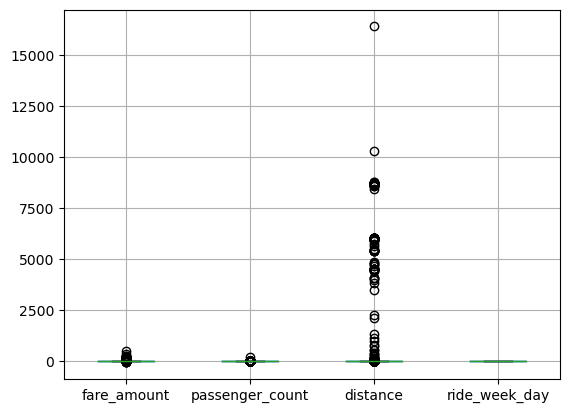

In [223]:
dfc.boxplot()
plt.show()

##### handling outliers

In [860]:
def check_and_handle_outliers(col):
    q1 = dfc[col].quantile(q = 0.25)
    q3 = dfc[col].quantile(q = 0.75)
    iqr = q3 - q1
    lower_boundary = q1 - (1.5 * iqr)
    upper_boundary = q3 + (1.5 * iqr)
    dfc[dfc[col] < lower_boundary]
    outliers = dfc[(dfc[col] < lower_boundary) | (dfc[col] > upper_boundary)]
    if len(outliers)>0 and ((len(outliers)//len(dfc))<(0.02*len(dfc))):
        print(f"{len(outliers)} Outliers Detected in {col}")
        remove_outliers(outliers,col,lower_boundary,upper_boundary)
    return 

In [861]:
def remove_outliers(outliers,col,lower_boundary,upper_boundary):
    for idx in outliers.index:
        val = dfc.loc[idx,col]
        if (val < lower_boundary):
            dfc.loc[idx,col] = lower_boundary
        elif (val > upper_boundary):
            dfc.loc[idx,col] = upper_boundary
    print(f"outliers handled for {col}")
    return 

In [226]:
dfc.describe()

,fare_amount,passenger_count,distance,ride_week_day
count,196166.000000,196166.000000,196166.000000,196166.000000
mean,11.411707,1.691109,21.262703,3.049025
std,9.936511,1.392449,386.676848,1.947039
min,-52.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,1.259661,1.000000
50%,8.500000,1.000000,2.164470,3.000000
75%,12.500000,2.000000,3.931749,5.000000
max,499.000000,208.000000,16409.239135,6.000000


In [366]:
for col in dfc.select_dtypes(include=np.number).columns:
    check_and_handle_outliers(col)

17054 Outliers Detected in fare_amount
outliers handled for fare_amount
22360 Outliers Detected in passenger_count
outliers handled for passenger_count
16518 Outliers Detected in distance
outliers handled for distance


In [367]:
dfc[df.fare_amount<0]

C:\Users\krant\AppData\Local\Temp\ipykernel_1508\50187627.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfc[df.fare_amount<0]


,fare_amount,passenger_count,distance,ride_week_day
63395,-3.75,1.0,0.325306,1
71246,-3.30,2.0,0.500646,3
79903,-3.50,1.0,0.383918,4
89322,-3.75,3.5,0.019203,1
92063,-3.75,3.0,7.939881,4
98875,-3.75,3.5,0.450054,4
104080,-3.75,1.0,1.997243,1
111589,-3.75,3.5,7.939881,0
139272,-3.75,1.0,1.820225,1
148803,-3.75,3.0,1.102572,4


##### Ideally, fare amounts should not be zero. Only possibility is the case of 100% discounted rides, which involves negative fare in company's pov

In [368]:
dft = dfc.drop(dfc[df.fare_amount<0].index)
dft[dft.fare_amount<0]

C:\Users\krant\AppData\Local\Temp\ipykernel_1508\2004437674.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dft = dfc.drop(dfc[df.fare_amount<0].index)


,fare_amount,passenger_count,distance,ride_week_day


In [369]:
X = dfc.drop(["fare_amount"],axis = 1)
X.head()

,passenger_count,distance,ride_week_day
0,1.0,1.683323,3
1,1.0,2.457590,4
2,1.0,5.036377,0
3,3.0,1.661683,4
4,3.5,4.475450,3


In [370]:
y = dfc["fare_amount"]

### Train Test Split

In [371]:
from sklearn.model_selection import train_test_split

In [372]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.70, random_state = 25)

In [373]:
len(y_train)

137316

### Model/Pipeline

In [374]:
from sklearn.pipeline import Pipeline

In [375]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [376]:
sc = StandardScaler()

In [489]:
pf = PolynomialFeatures(degree=3)

### Lin Reg

In [490]:
lr_model = LinearRegression()

In [491]:
steps = [("Poly_features", pf),("scaling",sc),("lor_model", lr_model)]

In [492]:
lr_pipeline = Pipeline(steps = steps, verbose = False)

In [493]:
lr_pipeline.fit(X_train,y_train)

Pipeline(steps=[('Poly_features', PolynomialFeatures(degree=3)),
                ('scaling', StandardScaler()),
                ('lor_model', LinearRegression())])

#### Prediction / Testing

In [494]:
y_pred = lr_pipeline.predict(X_test)

In [495]:
y_pred_train = lr_pipeline.predict(X_train)

### Evaluation

In [496]:
y_test = y_test.astype("float")

In [497]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [498]:
import math
test_mae = np.round(mean_absolute_error(y_test, y_pred),2)
test_mse = np.round(mean_squared_error(y_test, y_pred),2)
test_rmse = np.round(math.sqrt(test_mse),2)
test_r2s = np.round(r2_score(y_test, y_pred),2)

In [499]:
train_mae = np.round(mean_absolute_error(y_train, y_pred_train),2)
train_mse = np.round(mean_squared_error(y_train, y_pred_train),2)
train_rmse = np.round(math.sqrt(train_mse),2)
train_r2s = np.round(r2_score(y_train, y_pred_train),2)

In [500]:
print(f"Train Scores :: \ntrain_mae = {train_mae}\ntrain_rmse = {train_rmse}\ntrain_r2s = {train_r2s}\n\nTest Scores  :: \ntest_mae = {test_mae}\ntest_rmse = {test_rmse}\ntest_r2s = {test_r2s}")

Train Scores :: 
train_mae = 1.89
train_rmse = 2.79
train_r2s = 0.74

Test Scores  :: 
test_mae = 1.9
test_rmse = 2.8
test_r2s = 0.74


In [503]:
n=len(dfc)
k=len(X.columns)
adjusted_train_r2 = 1.0 - (1-train_r2s)*(n-1)/(n-k-1)
adjusted_test_r2 = 1.0 - (1-test_r2s)*(n-1)/(n-k-1)
print(f"adjusted_train_r2 = {adjusted_train_r2}\nadjusted_test_r2 = {adjusted_test_r2}")

adjusted_train_r2 = 0.7399960236947013
adjusted_test_r2 = 0.7399960236947013


### KNN

In [510]:
from sklearn.neighbors import KNeighborsRegressor 

In [608]:
knn_model = KNeighborsRegressor(n_neighbors = 21)

In [609]:
steps = [("scaling",sc),("knn_model", knn_model)]

In [610]:
knn_pipeline = Pipeline(steps = steps, verbose = False)

In [611]:
knn_pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('knn_model', KNeighborsRegressor(n_neighbors=21))])

#### Prediction / Testing

In [612]:
y_pred = knn_pipeline.predict(X_test)

In [613]:
y_pred_train = knn_pipeline.predict(X_train)

### Evaluation

In [614]:
y_test = y_test.astype("float")

In [615]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [616]:
import math
test_mae = np.round(mean_absolute_error(y_test, y_pred),2)
test_mse = np.round(mean_squared_error(y_test, y_pred),2)
test_rmse = np.round(math.sqrt(test_mse),2)
test_r2s = np.round(r2_score(y_test, y_pred),2)

In [617]:
train_mae = np.round(mean_absolute_error(y_train, y_pred_train),2)
train_mse = np.round(mean_squared_error(y_train, y_pred_train),2)
train_rmse = np.round(math.sqrt(train_mse),2)
train_r2s = np.round(r2_score(y_train, y_pred_train),2)

In [618]:
print(f"Train Scores :: \ntrain_mae = {train_mae}\ntrain_rmse = {train_rmse}\ntrain_r2s = {train_r2s}\n\nTest Scores  :: \ntest_mae = {test_mae}\ntest_rmse = {test_rmse}\ntest_r2s = {test_r2s}")

Train Scores :: 
train_mae = 1.75
train_rmse = 2.59
train_r2s = 0.77

Test Scores  :: 
test_mae = 1.83
test_rmse = 2.7
test_r2s = 0.76


In [619]:
n=len(dfc)
k=len(X.columns)
adjusted_train_r2 = 1.0 - (1-train_r2s)*(n-1)/(n-k-1)
adjusted_test_r2 = 1.0 - (1-test_r2s)*(n-1)/(n-k-1)
print(f"adjusted_train_r2 = {adjusted_train_r2}\nadjusted_test_r2 = {adjusted_test_r2}")

adjusted_train_r2 = 0.7699964824991589
adjusted_test_r2 = 0.7599963295643397


### DTR

In [620]:
from sklearn.tree import DecisionTreeRegressor 

In [771]:
dtr_model = DecisionTreeRegressor(random_state=50, max_depth=10, min_impurity_decrease=0.001)

In [772]:
steps = [("scaling",sc),("dtr_model", dtr_model)]

In [773]:
dtr_pipeline = Pipeline(steps = steps, verbose = False)

In [774]:
dtr_pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('dtr_model',
                 DecisionTreeRegressor(max_depth=10,
                                       min_impurity_decrease=0.001,
                                       random_state=50))])

#### Prediction / Testing

In [775]:
y_pred = dtr_pipeline.predict(X_test)

In [776]:
y_pred_train = dtr_pipeline.predict(X_train)

### Evaluation

In [777]:
y_test = y_test.astype("float")

In [778]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [779]:
import math
test_mae = np.round(mean_absolute_error(y_test, y_pred),2)
test_mse = np.round(mean_squared_error(y_test, y_pred),2)
test_rmse = np.round(math.sqrt(test_mse),2)
test_r2s = np.round(r2_score(y_test, y_pred),2)

In [780]:
train_mae = np.round(mean_absolute_error(y_train, y_pred_train),2)
train_mse = np.round(mean_squared_error(y_train, y_pred_train),2)
train_rmse = np.round(math.sqrt(train_mse),2)
train_r2s = np.round(r2_score(y_train, y_pred_train),2)

In [781]:
print(f"Train Scores :: \ntrain_mae = {train_mae}\ntrain_rmse = {train_rmse}\ntrain_r2s = {train_r2s}\n\nTest Scores  :: \ntest_mae = {test_mae}\ntest_rmse = {test_rmse}\ntest_r2s = {test_r2s}")

Train Scores :: 
train_mae = 1.78
train_rmse = 2.63
train_r2s = 0.77

Test Scores  :: 
test_mae = 1.79
test_rmse = 2.65
test_r2s = 0.77


In [782]:
n=len(dfc)
k=len(X.columns)
adjusted_train_r2 = 1.0 - (1-train_r2s)*(n-1)/(n-k-1)
adjusted_test_r2 = 1.0 - (1-test_r2s)*(n-1)/(n-k-1)
print(f"adjusted_train_r2 = {adjusted_train_r2}\nadjusted_test_r2 = {adjusted_test_r2}")

adjusted_train_r2 = 0.7699964824991589
adjusted_test_r2 = 0.7699964824991589


### RFR

In [791]:
from sklearn.ensemble import RandomForestRegressor 

In [848]:
rfr_model = RandomForestRegressor(n_estimators=100,criterion="squared_error",random_state=50,max_depth=10)

In [849]:
steps = [("scaling",sc),("rfr_model", rfr_model)]

In [850]:
rfr_pipeline = Pipeline(steps = steps, verbose = False)

In [851]:
rfr_pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('rfr_model',
                 RandomForestRegressor(max_depth=10, random_state=50))])

#### Prediction / Testing

In [852]:
y_pred = rfr_pipeline.predict(X_test)

In [853]:
y_pred_train = rfr_pipeline.predict(X_train)

### Evaluation

In [854]:
y_test = y_test.astype("float")

In [855]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [856]:
import math
test_mae = np.round(mean_absolute_error(y_test, y_pred),2)
test_mse = np.round(mean_squared_error(y_test, y_pred),2)
test_rmse = np.round(math.sqrt(test_mse),2)
test_r2s = np.round(r2_score(y_test, y_pred),2)

In [857]:
train_mae = np.round(mean_absolute_error(y_train, y_pred_train),2)
train_mse = np.round(mean_squared_error(y_train, y_pred_train),2)
train_rmse = np.round(math.sqrt(train_mse),2)
train_r2s = np.round(r2_score(y_train, y_pred_train),2)

In [858]:
print(f"Train Scores :: \ntrain_mae = {train_mae}\ntrain_rmse = {train_rmse}\ntrain_r2s = {train_r2s}\n\nTest Scores  :: \ntest_mae = {test_mae}\ntest_rmse = {test_rmse}\ntest_r2s = {test_r2s}")

Train Scores :: 
train_mae = 1.75
train_rmse = 2.57
train_r2s = 0.78

Test Scores  :: 
test_mae = 1.78
test_rmse = 2.64
test_r2s = 0.77


In [859]:
n=len(dfc)
k=len(X.columns)
adjusted_train_r2 = 1.0 - (1-train_r2s)*(n-1)/(n-k-1)
adjusted_test_r2 = 1.0 - (1-test_r2s)*(n-1)/(n-k-1)
print(f"adjusted_train_r2 = {adjusted_train_r2}\nadjusted_test_r2 = {adjusted_test_r2}")

adjusted_train_r2 = 0.779996635433978
adjusted_test_r2 = 0.7699964824991589


##### Conclusion - Linear Regression has the least adjusted R2 score